In [8]:
import netket as nk
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.append("c:/Users/vinit/Downloads/Research/Quantum-Sampling")
from spin_utils import *

In [59]:
# requirements:
#   netket >= 3
#   jax, jaxlib

import jax
import jax.numpy as jnp
import netket as nk

def build_rbm(n_spins: int, alpha: int = 1, sigma: float = 1.0):
    """
    Constructs the Hilbert space and an RBM model whose parameters
    (weights & biases) are initialized with standard normal N(0,1).
    """
    hi = nk.hilbert.Spin(s=0.5, N=n_spins)

    # Standard normal initializers for all trainable params
    normal_init = jax.nn.initializers.normal(sigma)

    model = nk.models.RBM(
        alpha=alpha,
        param_dtype=jnp.float64,          # use float64 for good numerical stability
        kernel_init=normal_init,          # W ~ N(0,1)
        visible_bias_init=normal_init,          # visible biases ~ N(0,1)
        hidden_bias_init=normal_init           # hidden biases ~ N(0,1)
    )
    return hi, model

def exact_state_vector(hi, model, seed: int) -> jnp.ndarray:
    """
    Builds an ExactState for a fresh random initialization and returns
    the normalized wavefunction |psi> as a length-2**N vector.
    """
    #vstate = nk.vqs.ExactState(hi, model, seed=seed)
    vstate = nk.vqs.FullSumState(hi, model, seed=seed)

    psi = vstate.to_array()              # amplitudes in computational basis
    # Normalize
    psi = psi / jnp.linalg.norm(psi)
    return psi


def entanglement_entropy(psi: jnp.ndarray, n_spins: int, n_A: int) -> float:
    """
    Computes the bipartite entanglement entropy S_A = -Tr(rho_A log rho_A)
    of a pure state |psi> for a subsystem A of n_A spins (out of n_spins total).
    """
    psi = psi / np.linalg.norm(psi)
    
    psi_reshaped = psi.reshape(2**n_A, 2**(n_spins - n_A))
    
    rho_A = psi_reshaped.conj() @ psi_reshaped.T

    # compute eigenvalues of rho_A
    evals = jnp.linalg.eigvalsh(rho_A)

    # compute entanglement entropy S_A = -Tr(rho_A log rho_A)
    evals = evals[evals > 1e-12]  # filter out tiny eigenvalues to avoid log(0)
    S_A = -jnp.sum(evals * jnp.log(evals))

    return float(S_A)


def average_projector_density_matrix(n_spins: int, n_samples: int, alpha: int = 1, seed: int = 1234, sigma: float = 1.0) -> jnp.ndarray:
    """
    Computes rho = (1/K) sum_k |psi_k><psi_k| over K random RBM inits.
    Returns rho with shape (2**N, 2**N).
    """
    hi, model = build_rbm(n_spins, alpha, sigma)
    dim = 2 ** n_spins

    # split seeds for reproducible, independent initializations
    base_key = jax.random.PRNGKey(seed)
    keys = jax.random.split(base_key, n_samples)

    # accumulate density matrices
    rho = jnp.zeros((dim, dim), dtype=jnp.complex128)
    
    for k in range(n_samples):
        psi = exact_state_vector(hi, model, seed=int(keys[k][0]))  # use each key as a seed
        rho = rho + jnp.outer(psi, jnp.conj(psi))
        S = entanglement_entropy(psi, n_spins, n_spins//2)
        entanglement_entropies.append(S)

    rho = rho / n_samples
    return rho

# if __name__ == "__main__":
N = 4          # number of spins/qubits -> Hilbert dimension = 2**N
K = 1000        # number of random RBM initializations to average over
alpha = 1      # RBM density (hidden units per visible)
seed = 42
sigma = 1   # stddev for normal initialization of RBM params
# ----------------------------------
entanglement_entropies = []

rho = average_projector_density_matrix(n_spins=N, n_samples=K, alpha=alpha, seed=seed, sigma=sigma)

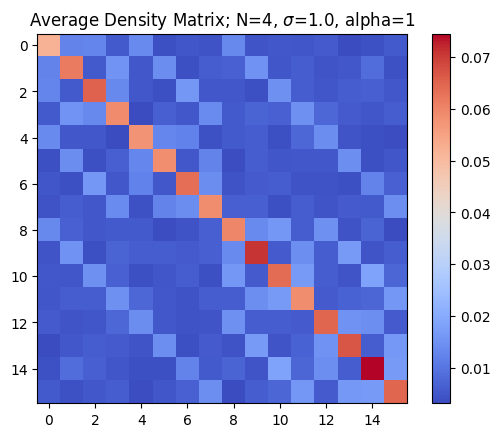

In [60]:
plt.title(r"Average Density Matrix; N=%d, $\sigma$=%.1f, alpha=%d" % (N, sigma, alpha))
plt.imshow(np.abs(rho), cmap='coolwarm')
plt.colorbar()

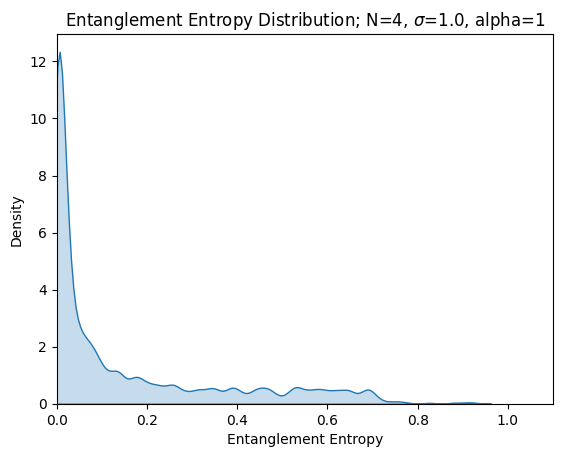

In [73]:
import seaborn as sns
plt.figure()
sns.kdeplot(entanglement_entropies, fill=True, bw_adjust=0.25)
# plt.hist(entanglement_entropies, bins=30, density=True)
plt.xlabel("Entanglement Entropy")
# np.linalg.norm(rho - Haar, ord=1)
plt.title(r"Entanglement Entropy Distribution; N=%d, $\sigma$=%.1f, alpha=%d" % (N, sigma, alpha))
plt.xlim(0, 1.1)
plt.show()

Trace distance from maximally mixed state = 0.06829952204566773


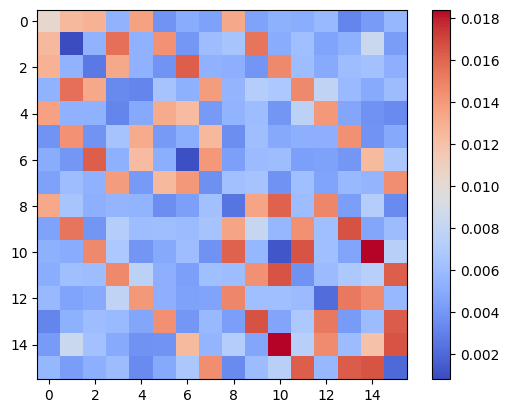

In [62]:
Haar = np.eye(2**N)/(2**N)
plt.imshow(np.abs(rho - Haar), cmap='coolwarm')
plt.colorbar()

# Trace distance from maximally mixed state
print("Trace distance from maximally mixed state =", np.linalg.norm(rho - Haar, ord=1) / 2 )